<a href="https://colab.research.google.com/github/clarawajdenbaum/Stroke-Predictions/blob/main/Stroke_Predictions_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
set_config(display='diagram')
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Project 2/docs/archive.zip', index_col = 'id')
corr = df.corr()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Preparing and Cleaning the Data

In [4]:
df.shape # This set of data contains 5110 rows and 12 columns.

(5110, 11)

In [5]:
df.duplicated().sum()

0

In [7]:
df.isna().sum()   # The 'bmi' column contains missing data.

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [8]:
df.dropna(subset=['bmi'], inplace=True) # I remove the rows with missing values as it is only 3% of our data.
df.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
df.shape  # The shape of our data after cleaning is 4909 rows and 11 columns.

(4909, 11)

In [10]:
# Let's check for inconsistencies in our data

print('Columns Types:')
print(df.dtypes)
print('\n')
print('Value Counts:')
print(df.value_counts())

# There are no inconsistencies in our data

Columns Types:
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object


Value Counts:
gender  age    hypertension  heart_disease  ever_married  work_type      Residence_type  avg_glucose_level  bmi   smoking_status   stroke
Female  0.08   0             0              No            children       Urban           139.67             14.1  Unknown          0         1
Male    15.00  0             0              No            children       Rural           62.57              32.3  never smoked     0         1
                                                                         Urban           113.28             23.7  never smoked     0         1
                                                                     

In [11]:
# Identifying target vector and features

y = df['stroke']  # Target vector 
X = df.drop(columns='stroke')   # Features matrix

# Exploratory Visualizations

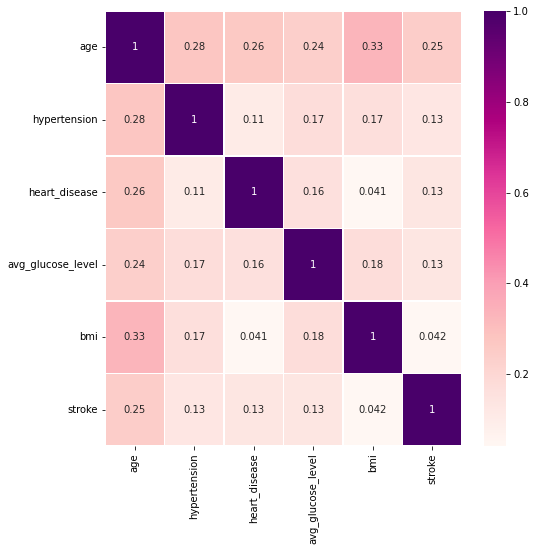

In [12]:
plt.figure(figsize=(8,8));
sns.heatmap(corr, cmap = 'RdPu', annot = True, linewidths=.5);

In [ ]:
# There are no strong or moderate correlations between the features and target or between features together.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


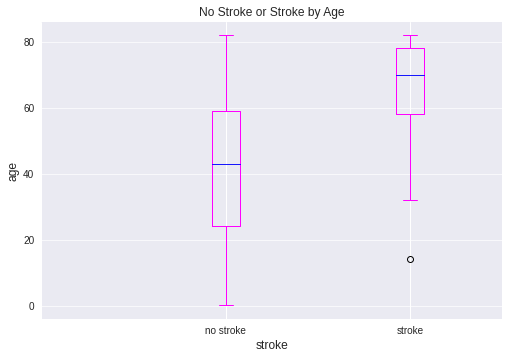

In [13]:
plt.style.use('seaborn');
df.boxplot(column = 'age', by = 'stroke', color='magenta', medianprops=dict(color="blue", alpha=0.9));
plt.ylabel('age', fontsize = 12);
plt.xlabel('stroke', fontsize = 12);
plt.title('No Stroke or Stroke by Age');
plt.suptitle('');
plt.grid(axis='y', c='w', alpha=0.7, linestyle='-');
plt.xticks([0, 1, 2], ['', 'no stroke', 'stroke']);

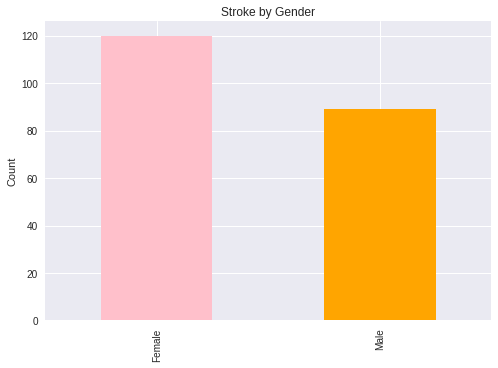

In [14]:
plt.style.use('seaborn');
df_stroke = df[df['stroke']==1]
gender_stroke = df_stroke['gender'].value_counts()
gender_stroke.plot(kind='bar', color=['pink', 'orange']);
plt.title('Stroke by Gender')
plt.ylabel('Count')
plt.show()

In [15]:
print(df['gender'].value_counts())
print('\n')
print(df['stroke'].value_counts())

Female    2897
Male      2011
Other        1
Name: gender, dtype: int64


0    4700
1     209
Name: stroke, dtype: int64


In [ ]:
# In this graph we can see that more women have strokes than men but in our dataset we have more women than me. 
# 60% of our dataset is female.
# 57.4% of strokes are female.
# Following those percentages, we can't say that female are more susceptible to strokes than males.

# Preprocessing

In [16]:
# gender = nominal feature
# age = numerical feature
# hypertension = nominal feature
# heart_disease = nominal feature
# ever_married = nominal feature
# work_type = nominal feature
# Residence_type = nominal feature
# avg_glucose_level = numerical feature
# bmi = numerical feature
# smoking_status = nominal feature

In [17]:
# Identifying target vector and features
y = df['stroke']  # Target vector 
X = df.drop(columns='stroke')   # Features matrix

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [18]:
# Column selectors
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [19]:
# Scale the numerical features (as most models need scaling)
# OneHotEncode the nominal feature 

scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [20]:
# ColumnTransformer
num = (scaler, num_selector)
cat = (ohe, cat_selector)
preprocessor = make_column_transformer(num, cat)
preprocessor

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7a498ad90>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fa7a498add0>)])

In [21]:
# Transform data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [22]:
# Insepcting results (source: "https://login.codingdojo.com/m/213/7153/70749")
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (3681, 21)




array([[-0.52064637, -0.31745474, -0.22475253, ...,  1.        ,
         0.        ,  0.        ],
       [-1.81017863, -0.31745474,  4.44933817, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.76888589, -0.31745474, -0.22475253, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.45761948, -0.31745474, -0.22475253, ...,  1.        ,
         0.        ,  0.        ],
       [-1.40997896, -0.31745474, -0.22475253, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.90228578, -0.31745474, -0.22475253, ...,  1.        ,
         0.        ,  0.        ]])

# Modeling

Classification Tree

In [24]:
df['stroke'].value_counts(normalize = True) # (Our data is very inbalanced)

0    0.957425
1    0.042575
Name: stroke, dtype: float64

In [25]:
# Make an instance of the Model (using default parameters)
dec_tree = DecisionTreeClassifier(random_state = 42)

# Fit the model on the training data
dec_tree.fit(X_train_processed, y_train)

# Predict the target values for the test set
dec_tree.predict(X_test_processed)

# Evaluate the Model (using the r^2 metric)
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

1.0
0.9039087947882736


In [26]:
# Our data has a score of 100% on the training set and does very well on the testing set but let's see if we can still improve it.

In [27]:
# The depth of our default tree 
dec_tree.get_depth()

21

In [28]:
# Number of leaf nodes our tree had.
dec_tree.get_n_leaves()

230

In [29]:
# GridSearchCV to find the parameters
# Source: "https://login.codingdojo.com/m/213/7198/89532"

model = DecisionTreeClassifier()
param_grid = {'max_depth': [5,10,15,20,21],
              'min_samples_leaf': [10,20,40,50,100, 150,200,230],
              'min_samples_split': [2, 10, 100]}
scores = {}
for d in param_grid['max_depth']:
  for l in param_grid['min_samples_leaf']:
    for s in param_grid['min_samples_split']:
      model = DecisionTreeClassifier(max_depth=d,
                                     min_samples_leaf=l,
                                     min_samples_split=s)
      model.fit(X_train_processed, y_train)
      score = model.score(X_test_processed, y_test)
      scores[f'depth {d}, min_samples_leaf {l}, min_samples_split {s} accuracy'] = score.round(6) * 100
 
scores

{'depth 10, min_samples_leaf 10, min_samples_split 10 accuracy': 94.7068,
 'depth 10, min_samples_leaf 10, min_samples_split 100 accuracy': 94.8697,
 'depth 10, min_samples_leaf 10, min_samples_split 2 accuracy': 94.7068,
 'depth 10, min_samples_leaf 100, min_samples_split 10 accuracy': 94.8697,
 'depth 10, min_samples_leaf 100, min_samples_split 100 accuracy': 94.8697,
 'depth 10, min_samples_leaf 100, min_samples_split 2 accuracy': 94.8697,
 'depth 10, min_samples_leaf 150, min_samples_split 10 accuracy': 94.8697,
 'depth 10, min_samples_leaf 150, min_samples_split 100 accuracy': 94.8697,
 'depth 10, min_samples_leaf 150, min_samples_split 2 accuracy': 94.8697,
 'depth 10, min_samples_leaf 20, min_samples_split 10 accuracy': 94.8697,
 'depth 10, min_samples_leaf 20, min_samples_split 100 accuracy': 94.8697,
 'depth 10, min_samples_leaf 20, min_samples_split 2 accuracy': 94.8697,
 'depth 10, min_samples_leaf 200, min_samples_split 10 accuracy': 94.8697,
 'depth 10, min_samples_leaf 20

In [30]:
dt_grid_search = GridSearchCV(model, param_grid)

# fit the model on the training set
dt_grid_search.fit(X_train_processed, y_train)

dt_grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}

In [31]:
best_model = dt_grid_search.best_estimator_

# fit the model on the training set
best_model.fit(X_train_processed, y_train)

best_model.score(X_test_processed, y_test)

0.9486970684039088

In [32]:
# Scores by adjusting the parameters

dec_tree_best = DecisionTreeClassifier(max_depth=5, min_samples_leaf=20, min_samples_split=2, random_state=42)
dec_tree_best.fit(X_train_processed, y_train)
predictions_dt = dec_tree_best.predict(X_test_processed)
train_score_best = dec_tree_best.score(X_train_processed, y_train)
test_score_best = dec_tree_best.score(X_test_processed, y_test)
print(train_score_best)
print(test_score_best)

0.9603368649823417
0.9486970684039088


K-Nearest Neighbors (KNN)

In [33]:
# Make an instance of the Model (using default parameters)
knn = KNeighborsClassifier()

# Create a pipeline 
knn_pipe = make_pipeline(scaler, knn)

# Fit the model on the training data
knn_pipe.fit(X_train_processed, y_train)

# Predict the target values for the test set
predictions = knn_pipe.predict(X_test_processed)

# Evaluate the model
acc_score = knn_pipe.score(X_test_processed, y_test)
acc_score

0.9470684039087948

In [34]:
# GridSearchCV to find the parameters
# Source: "https://login.codingdojo.com/m/213/7198/89532"

pipe_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
              'kneighborsclassifier__p': range(1,5),
              'kneighborsclassifier__weights': ['distance','uniform']}
knn_pipe_gs = GridSearchCV(knn_pipe, pipe_param_grid)
knn_pipe_gs.fit(X_train_processed, y_train)
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(best_pipe.score(X_test_processed, y_test))

{'kneighborsclassifier__n_neighbors': 6, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}
0.9486970684039088


Logistic Regression

In [35]:
# Instance of the model
logreg = LogisticRegression()

# Pipeline
logreg_pipe = make_pipeline(scaler, logreg)

# Training the data
logreg_pipe.fit(X_train_processed, y_train)

# Predict the test set
predictions_lr = logreg_pipe.predict(X_test_processed)

# Evaluate the model
print(logreg_pipe.score(X_train_processed, y_train))
print(logreg_pipe.score(X_test_processed, y_test))

0.9606085302906818
0.9486970684039088


{0.0001: 0.9486970684039088,
 0.001: 0.9486970684039088,
 0.01: 0.9486970684039088,
 0.1: 0.9486970684039088,
 1: 0.9486970684039088,
 10: 0.9486970684039088,
 100: 0.9486970684039088,
 1000: 0.9486970684039088}

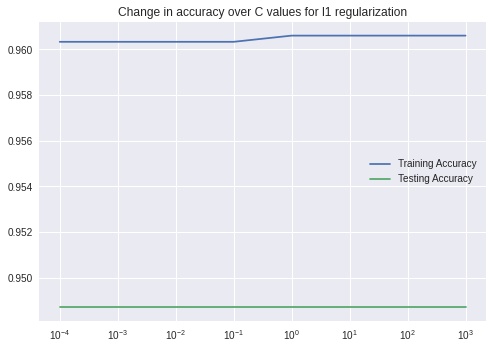

In [36]:
# L1 Tuning 

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
for c in c_values:
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train_processed, y_train)
  train_scores.append(log_reg_pipe.score(X_train_processed, y_train))
  test_scores.append(log_reg_pipe.score(X_test_processed, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_scores)}

{0.0001: 0.9486970684039088,
 0.001: 0.9486970684039088,
 0.01: 0.9486970684039088,
 0.1: 0.9486970684039088,
 1: 0.9486970684039088,
 10: 0.9486970684039088,
 100: 0.9486970684039088,
 1000: 0.9486970684039088}

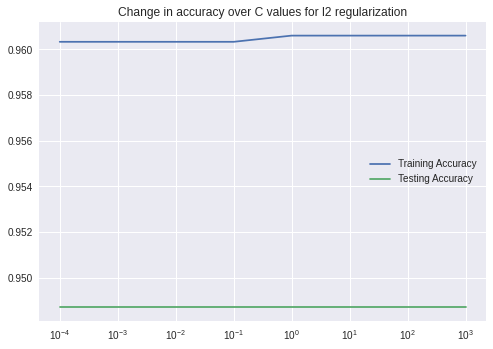

In [37]:
# L2 Tuning 

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_scores = []
test_scores = []
for c in c_values:
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train_processed, y_train)
  train_scores.append(log_reg_pipe.score(X_train_processed, y_train))
  test_scores.append(log_reg_pipe.score(X_test_processed, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, train_scores, label='Training Accuracy')
ax.plot(c_values, test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
ax.set_xscale('log')
{c:score for c, score in zip(c_values, test_scores)}

# Summary:

The Classification Tree model with 'max_depth' of 5, 'min_samples_leaf' of 20 and 'min_samples_split' of 2 and the Logistic Regression Tree model have the same score on the testing set. They have an accuracy score of 94.87%.

The KNN model with kneighborsclassifier__n_neighbors'of 6, 'kneighborsclassifier__p' of 1 and 'kneighborsclassifier__weights' of 'uniform' has a score of 94.71% which is very slightly lower.

All three of our models work very well on our test set but I will choose the **Classification Tree** as I think it is the easiest one to use and also has the best score.

# Sources:

All the codes come from 'Coding Dojo'.